# Vision Transformer encoder from scratch

In [19]:
%load_ext autoreload
%autoreload 2

import copy

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from PIL import Image
from torch import Tensor, nn
from torch.nn import LayerNorm

# from torchsummary import summary
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

from utils.trainer import Trainer

### Patch embedding

Using the rearange method, we have:

* `b` the number of batches, here its one
* `c` the number of channels, here its $3$
* `(h s1)` is the total height ($224$), `s1` is the patch size ($16$) therefore `h` is $224/16$ which is $14$ 
* `(w s2)` is the total width ($224$), `s2` is the patch size ($16$) therefore `w` is $224/16$ which is $14$ 

We want to flatten all the patches.
That means we will end up with:

* `b`still the number of batch
* `(h w)` the number of patches, therefore $14 * 14 = 196$ patches
* `(s1 s2 c)` the size of the patches multiplied by the number of channels, that means each patch will be $768$ pixels


In [2]:
class PatchEmbedding(nn.Module):
    def __init__(
        self,
        *,
        in_channels: int,
        img_size: int,
        patch_size: int = 16,
        emb_size: int = 512,
        is_SPT: bool = False,
    ):
        super().__init__()
        assert (
            img_size % patch_size == 0
        ), f"{img_size=}, needs to be a multiple of {patch_size=}"

        if is_SPT:
            self.patch_shifting = PatchShifting(patch_size)
            in_channels *= 5

        self.patch_size = patch_size
        self.to_patch = Rearrange(
            "b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=patch_size, p2=patch_size
        )
        self.linear = nn.Linear(patch_size**2 * in_channels, emb_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(
            torch.randn((img_size // patch_size) ** 2 + 1, emb_size)
        )
        self.is_SPT = is_SPT

    def forward(self, x: Tensor) -> Tensor:

        if self.is_SPT:
            x = self.patch_shifting(x)

        x = self.to_patch(x)
        x = self.linear(x)

        batch_size = x.shape[0]
        cls_tokens = repeat(self.cls_token, "() n e -> b n e", b=batch_size)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions

        return x

In [3]:
class PatchShifting(nn.Module):
    def __init__(self, patch_size):
        super().__init__()
        self.shift = int(patch_size * (1 / 2))

    def forward(self, x):

        x_pad = torch.nn.functional.pad(
            x, (self.shift, self.shift, self.shift, self.shift)
        )
        # if self.is_mean:
        #     x_pad = x_pad.mean(dim=1, keepdim = True)

        """ 4 cardinal directions """
        #############################
        # x_l2 = x_pad[:, :, self.shift:-self.shift, :-self.shift*2]
        # x_r2 = x_pad[:, :, self.shift:-self.shift, self.shift*2:]
        # x_t2 = x_pad[:, :, :-self.shift*2, self.shift:-self.shift]
        # x_b2 = x_pad[:, :, self.shift*2:, self.shift:-self.shift]
        # x_cat = torch.cat([x, x_l2, x_r2, x_t2, x_b2], dim=1)
        #############################

        """ 4 diagonal directions """
        # #############################
        x_lu = x_pad[:, :, : -self.shift * 2, : -self.shift * 2]
        x_ru = x_pad[:, :, : -self.shift * 2, self.shift * 2 :]
        x_lb = x_pad[:, :, self.shift * 2 :, : -self.shift * 2]
        x_rb = x_pad[:, :, self.shift * 2 :, self.shift * 2 :]
        out = torch.cat([x, x_lu, x_ru, x_lb, x_rb], dim=1)
        # #############################

        """ 8 cardinal directions """
        #############################
        # x_l2 = x_pad[:, :, self.shift:-self.shift, :-self.shift*2]
        # x_r2 = x_pad[:, :, self.shift:-self.shift, self.shift*2:]
        # x_t2 = x_pad[:, :, :-self.shift*2, self.shift:-self.shift]
        # x_b2 = x_pad[:, :, self.shift*2:, self.shift:-self.shift]
        # x_lu = x_pad[:, :, :-self.shift*2, :-self.shift*2]
        # x_ru = x_pad[:, :, :-self.shift*2, self.shift*2:]
        # x_lb = x_pad[:, :, self.shift*2:, :-self.shift*2]
        # x_rb = x_pad[:, :, self.shift*2:, self.shift*2:]
        # x_cat = torch.cat([x, x_l2, x_r2, x_t2, x_b2, x_lu, x_ru, x_lb, x_rb], dim=1)
        #############################

        return out

### Attention

the attention takes three inputs, the famous queries, keys, and values, and computes the attention matrix using queries and values and use it to “attend” to the values.

First step is to split key, queries and values, we will go step by step for queries, keys and values follow the same pattern.
* The input go trough a linear layer
* we rearange the input
    * `b` the batch size
    * `n` the number of patches
    * `(h d)` the size of one patch where `h` is the number of heads so `d` is the size of a patch given to an attention head.
    * We rearange that into, the same batch size, but now we have `h` patches that each will handle the full amount of patches but of size `d`
    
Now that we have our `keys` `values` and `queries` in the right shape, we can perform a `matrix multiplication` between the `keys` and the `queries`.

The attention map is then the softmax of this resulting matrix divided by some scaling.

We parform a matrix multiplication and rearange the result back together.

In [60]:
class MultiHeadAttention(nn.Module):
    def __init__(
        self,
        *,
        emb_size: int = 512,
        num_heads: int = 8,
        dropout: float = 0.1,
        is_LSA: bool = False
    ):
        super().__init__()
        self.num_heads = num_heads

        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)

        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

        self.scaling = emb_size ** (1 / 2)
        self.is_LSA = is_LSA

        if is_LSA:
            num_patches = 5
            self.scaling = nn.Parameter(self.scaling * torch.ones(1))
            self.mask = torch.eye(num_patches, num_patches)
            self.mask = torch.nonzero((self.mask == 1), as_tuple=False)

    def forward(self, x):
        # split keys, queries and values in num_heads
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)

        # sum up over the last axis
        attention_weights = torch.einsum(
            "bhqd, bhkd -> bhqk", queries, keys
        )  # batch, num_heads, query_len, key_len

        if self.is_LSA:
            attention_weights[:, :, self.mask[:, 0], self.mask[:, 1]] = -987654321

        attention_weights = F.softmax(attention_weights / self.scaling, dim=-1)
        attention_weights = self.att_drop(attention_weights)

        # sum up over the third axis
        out = torch.einsum("bhal, bhlv -> bhav ", attention_weights, values)
        out = rearrange(out, "b h n d -> b n (h d)")  # concat the heads
        out = self.projection(out)  # project out

        return out

### Encoder

In [61]:
class EncoderBlock(nn.Module):
    """
    A transformer Encoder Block is a layerNorm foloowed by a MultiHeadAttention,
    another layerNorm and finally a linearLayer.
    """

    def __init__(
        self, *, emb_size: int = 512, num_heads: int = 8, is_LSA: bool = False
    ):
        super().__init__()

        self.mha = MultiHeadAttention(
            emb_size=emb_size, num_heads=num_heads, is_LSA=is_LSA
        )
        self.layer_norm_1 = LayerNorm(emb_size)
        self.layer_norm_2 = LayerNorm(emb_size)
        dropout = 0.1

        self.feed_forward = nn.Sequential(
            nn.Linear(emb_size, 4 * emb_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4 * emb_size, emb_size),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, **kwargs):
        residual = x
        x = self.layer_norm_1(x)
        x = self.mha(x)
        x = self.dropout(x)
        x = x + residual

        residual = x
        x = self.layer_norm_2(x)
        x = self.feed_forward(x)
        x = self.dropout(x)
        x = x + residual

        return x

In [62]:
class TransformerEncoder(nn.Module):
    """
    Consists of `depth` encoder blocks chained together.
    """

    def __init__(
        self,
        *,
        depth: int = 1,
        emb_size: int = 512,
        num_heads: int = 8,
        is_LSA: bool = False
    ):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                EncoderBlock(emb_size=emb_size, num_heads=num_heads, is_LSA=is_LSA)
                for _ in range(depth)
            ]
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### Classification head

In [63]:
class ClassificationHead(nn.Sequential):
    def __init__(self, *, emb_size: int = 512, n_classes: int = 1000):
        super().__init__(
            Reduce(
                "b n e -> b e", reduction="mean"
            ),  # Reduce the N patches into One patch by averaging them
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes),
        )

### ViT

In [64]:
class ViT(nn.Sequential):
    def __init__(
        self,
        *,
        in_channels: int,
        img_size: int,
        n_classes: int = 10,
        patch_size: int = 8,
        emb_size: int = 192,
        num_heads=12,
        depth: int = 1,
        is_SPT: bool = False,
        is_LSA: bool = False
    ):
        super().__init__()

        self.patch_embeding = PatchEmbedding(
            in_channels=in_channels,
            img_size=img_size,
            patch_size=patch_size,
            emb_size=emb_size,
            is_SPT=is_SPT,
        )

        self.transformer_encoders = TransformerEncoder(
            depth=depth, emb_size=emb_size, num_heads=num_heads, is_LSA=is_LSA
        )

        self.classification_head = ClassificationHead(
            emb_size=emb_size, n_classes=n_classes
        )

    def forward(self, x):
        x = self.patch_embeding(x)
        x = self.transformer_encoders(x)
        x = self.classification_head(x)
        return x

--- 

## Loading dataset

Dataset choosen here is [cifar10](https://www.cs.toronto.edu/~kriz/cifar.html)

In [65]:
from autoaugment import CIFAR10Policy

batch_size = 256
transform = Compose(
    [Resize((32, 32)), CIFAR10Policy(), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


In [66]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(24, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    plt.show()


# get some random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# # show images
# imshow(torchvision.utils.make_grid(images))
# # print labels
# print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

---

## Training

In [23]:
device = "cuda"

In [41]:
model = ViT(
    in_channels=3,
    img_size=32,
    patch_size=16,
    num_heads=8,
    depth=3,
    n_classes=10,
    emb_size=512,
    is_SPT=False,
    is_LSA=False
).to(
    device
)  # this should give us 4 patches for each images and only one encoder block with one attention head

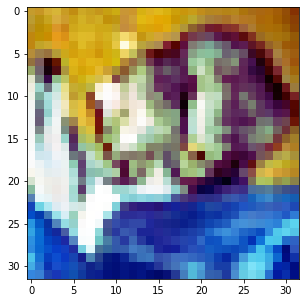

tensor([3], device='cuda:0')
tensor([[ 1.1568, -0.2250, -0.4941,  1.0923, -0.4997, -0.0336, -1.0338,  0.2099,
         -0.2053, -0.0790]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(1.4311, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0., device='cuda:0')


In [59]:
testloader_b1 = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=False, num_workers=2
)
from torchmetrics import Accuracy

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=0.05)
accuracy = Accuracy(task="multiclass", num_classes=10).to(device);
lr_decay = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

for img, label in testloader_b1:
    img, label = (img.to(device), label.to(device))
    y = model(img)
    l = criterion(y, label)
    acc = accuracy(y, label)
    imshow(img.cpu()[0])
    print(label)
    print(y)
    print(l)
    print(acc)
    break

In [54]:
trainer = Trainer(
    model,
    device,
    criterion,
    optimizer,
    trainloader,
    testloader,
    lr_scheduler=lr_decay,
    score_function=accuracy,
    epochs=100,
    notebook=True,
)

In [56]:
trainer.run_trainer()

Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Validation loss decreased (inf --> 1.541337).  Saving model ...


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Validation loss decreased (1.541337 --> 1.501003).  Saving model ...


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Validation loss decreased (1.501003 --> 1.477599).  Saving model ...


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Validation loss decreased (1.477599 --> 1.445690).  Saving model ...


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Validation loss decreased (1.445690 --> 1.420750).  Saving model ...


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Validation loss decreased (1.420750 --> 1.412088).  Saving model ...


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 7


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 7


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

EarlyStopping counter: 4 out of 7


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

EarlyStopping counter: 5 out of 7


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

EarlyStopping counter: 6 out of 7


Training:   0%|          | 0/196 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

EarlyStopping counter: 7 out of 7
Early Stopping


([2.2513467535680656,
  2.0312843845815074,
  1.959501955582171,
  1.8899368856634413,
  1.8310776267732893,
  1.8143795765176112,
  1.810422662569552,
  1.8296628922832257,
  1.8263164880324383,
  1.8153897572536857,
  1.7899872946495912,
  1.7477599376318407,
  1.6941319971668476,
  1.6357562724424868,
  1.5764095619016765,
  1.559282262106331,
  1.5624479663615325,
  1.5828123670451495,
  1.6187350567506285,
  1.6268041991457647,
  1.6103533378669195,
  1.5737698394425061,
  1.5138169703434925,
  1.4517904325407378,
  1.3799497923072503,
  1.3588830494150823,
  1.35701214902255,
  1.3940464702187751,
  1.4422228895888036,
  1.4643902602244396,
  1.4465952175004142,
  1.413608607588982,
  1.3509999160863915,
  1.269441430057798,
  1.1814248011428483,
  1.155617586508089,
  1.1539978053496809,
  1.193910792165873,
  1.251020266085255,
  1.2919492904020815,
  1.2922489162610502,
  1.2579330230245784,
  1.1864526174506362,
  1.08028132240383],
 [2.090595379471779,
  1.9763971269130707,


In [57]:
model.load_state_dict(torch.load("../weights/checkpoint.pt"))
# trainer.save_training_metric("test")

<All keys matched successfully>

In [58]:
trainer.validation_score

[0.2234375,
 0.2728515625,
 0.30283203125,
 0.3291015625,
 0.34423828125,
 0.34677734375,
 0.3515625,
 0.34052734375,
 0.34208984375,
 0.34853515625,
 0.35234375,
 0.36796875,
 0.3880859375,
 0.4064453125,
 0.41767578125,
 0.4154296875,
 0.42138671875,
 0.42587890625,
 0.4119140625,
 0.40390625,
 0.41787109375,
 0.41904296875,
 0.44150390625,
 0.45810546875,
 0.45634765625,
 0.4724609375,
 0.4705078125,
 0.46396484375,
 0.44921875,
 0.4396484375,
 0.4482421875,
 0.4640625,
 0.473828125,
 0.4951171875,
 0.50498046875,
 0.501953125,
 0.510546875,
 0.49208984375,
 0.47646484375,
 0.4638671875,
 0.48603515625,
 0.4810546875,
 0.49482421875,
 0.51181640625]

In [ ]:
# 0.520 with is_LSA 5 epochs
# 0.527 with is_SPT 5 epochs
# 0.522 with vanilla 5 epochs
# 